In [3]:
! git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [4]:
! ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [6]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/train.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/train.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [7]:
assert(X_train.shape[0] == y_train.shape[0]) , "the number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]) , "the number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]) , "the number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(34799, 32, 32, 3)
(34799, 32, 32, 3)


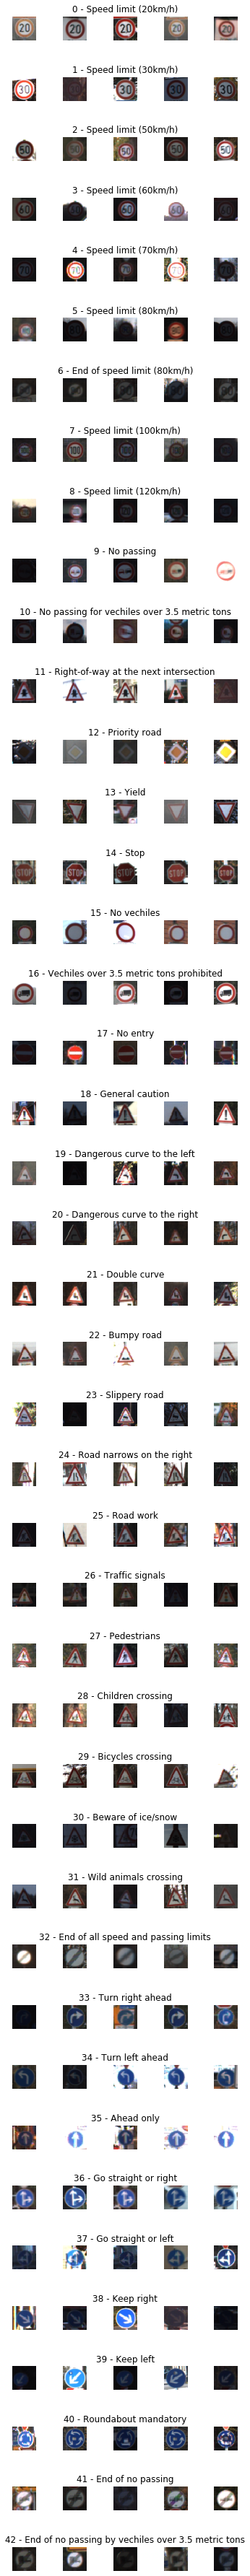

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


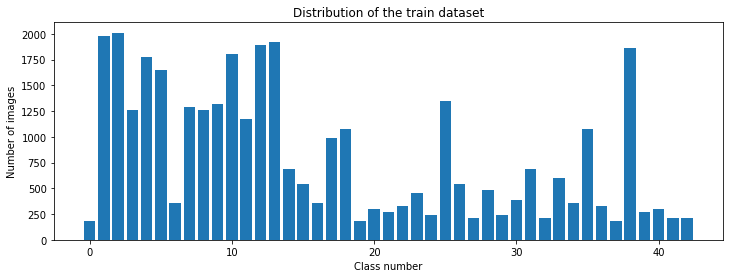

In [9]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [0]:
import cv2

(32, 32, 3)
36


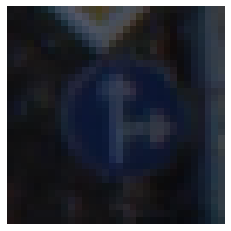

In [11]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


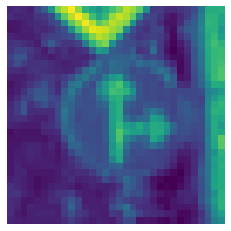

In [12]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


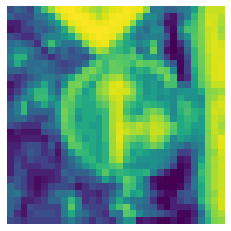

In [13]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [0]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


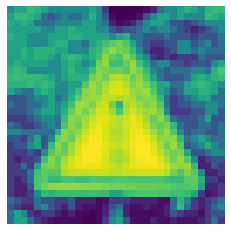

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train))])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(34799, 32, 32, 1)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(34799, 32, 32, 1)
(34799, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


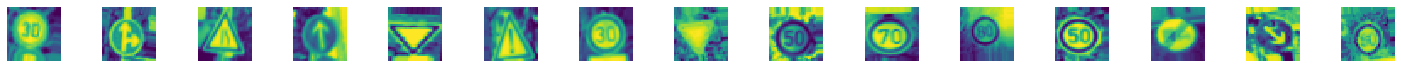

In [21]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
model = modified_model()
print(model.summary())







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

In [24]:
history =model.fit(X_train, y_train, batch_size=50,epochs=10,validation_data=(X_val, y_val), shuffle = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 34799 samples, validate on 34799 samples
Epoch 1/10





34799/34799 [==============================] - 23s 659us/step - loss: 0.7817 - acc: 0.7792 - val_loss: 0.0926 - val_acc: 0.9767
Epoch 2/10
34799/34799 [==============================] - 7s 206us/step - loss: 0.1336 - acc: 0.9600 - val_loss: 0.0367 - val_acc: 0.9899
Epoch 3/10
34799/34799 [==============================] - 7s 214us/step - loss: 0.0869 - acc: 0.9726 - val_loss: 0.0233 - val_acc: 0.9934
Epoch 4/10
34799/34799 [==============================] - 7s 210us/step - loss: 0.0627 - acc: 0.9807 - val_loss: 0.0234 - val_acc: 0.9926
Epoch 5/10
34799/34799 [==============================] - 7s 211us/step - loss: 0.0493 - acc: 0.9841 - val_loss: 0.0133 - val_acc: 0.9955
Epoch 6/10
34799/34799 [==============================] - 7s 211us/step - loss: 0.0445 - acc: 0.9860 - val_loss: 0.0117 - val_acc: 0.9966
Epoch 7/10
34799/34

Text(0.5, 0, 'epoch')

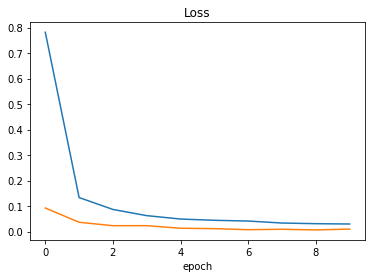

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

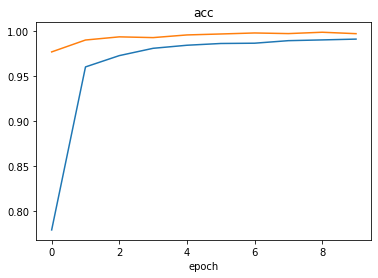

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('acc')
plt.xlabel('epoch')

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.009963929316312996
Test accuracy: 0.9969251989999712


# **Testing of Our Model**

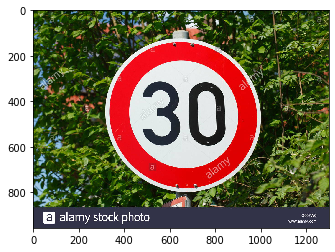

In [28]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


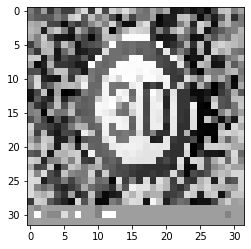

In [29]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1 ,32, 32, 1)

In [31]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [1]
